In [26]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import geopandas as gpd
import requests
from shapely.geometry import box
from odc.geo.geobox import GeoBox
from odc.stac import configure_rio, stac_load
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import folium
import folium.plugins

In [27]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/laserglaciers/miniconda3/envs/py310v2/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 48489 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:48489/status,
Dashboard: http://127.0.0.1:48489/status,Workers: 4
Total threads: 12,Total memory: 15.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37975,Workers: 4
Dashboard: http://127.0.0.1:48489/status,Total threads: 12
Started: Just now,Total memory: 15.45 GiB
Comm: tcp://127.0.0.1:40713,Total threads: 3
Dashboard: http://127.0.0.1:36729/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:47753,


In [28]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=pc.sign_inplace)
upvk_mel = gpd.read_file('/media/laserglaciers/upernavik/iceberg_py/geoms/upernavik/upvk_mel_box_4326.gpkg')
minx, miny, maxx, maxy = upvk_mel.geometry.total_bounds
kbox = box(minx, miny, maxx, maxy)

query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = "2020-08",
    query = {"eo:cloud_cover": {"lt": 10}},
    bbox = upvk_mel.geometry.total_bounds
    )

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 60 datasets


In [29]:
stac_json = query.item_collection_as_dict()

In [30]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
gdf.head()

,geometry,datetime,platform,proj:epsg,instruments,s2:mgrs_tile,constellation,s2:granule_id,eo:cloud_cover,s2:datatake_id,...,s2:cloud_shadow_percentage,s2:nodata_pixel_percentage,s2:unclassified_percentage,s2:dark_features_percentage,s2:not_vegetated_percentage,s2:degraded_msi_data_percentage,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
0,"POLYGON ((-54.22711 73.86801, -50.68484 73.892...",2020-08-31T15:59:11.024000Z,Sentinel-2A,32622,[msi],22XDG,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20200907T193005_A0271...,0.000534,GS2A_20200831T155911_027121_N02.12,...,0.000000,0.000000,0.000000,0.000003,0.000000,0.0,0.000000,0.980446,0.000000,0.0
1,"POLYGON ((-54.06201 72.97278, -50.70099 72.995...",2020-08-31T15:59:11.024000Z,Sentinel-2A,32622,[msi],22XDF,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20200907T193022_A0271...,0.448934,GS2A_20200831T155911_027121_N02.12,...,0.268765,0.000013,2.115776,3.870263,3.940021,0.0,0.038202,0.980446,0.405752,0.0
2,"POLYGON ((-53.93924 72.9728, -50.59827 72.8951...",2020-08-31T15:59:11.024000Z,Sentinel-2A,32621,[msi],21XXA,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20200907T193020_A0271...,0.548485,GS2A_20200831T155911_027121_N02.12,...,0.277637,0.000003,2.513592,4.711023,4.784440,0.0,0.050498,0.980446,0.489570,0.0
3,"POLYGON ((-54.05588 72.93467, -54.0051 72.9641...",2020-08-30T15:38:19.024000Z,Sentinel-2B,32622,[msi],22XDG,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20200907T171626_A0181...,0.012002,GS2B_20200830T153819_018198_N02.12,...,0.000000,39.128646,0.000000,0.000011,0.000000,0.0,0.000000,0.979993,0.000000,0.0
4,"POLYGON ((-54.05572 72.93475, -54.0051 72.9641...",2020-08-30T15:38:19.024000Z,Sentinel-2B,32622,[msi],22XDF,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20200907T171411_A0181...,3.214775,GS2B_20200830T153819_018198_N02.12,...,0.249608,0.042654,2.078909,3.285521,3.346705,0.0,0.050801,0.979993,0.819906,0.0


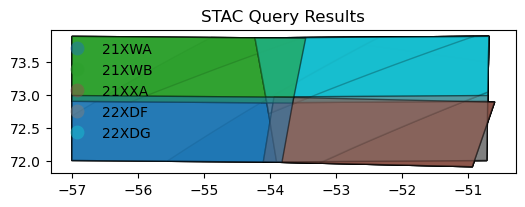

In [31]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
# gdf["granule"] = (
#     gdf["proj:epsg"]
#     + gdf["s2:mgrs_tile"]
# )

fig = gdf.plot(
    "s2:mgrs_tile",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [32]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [33]:
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    kbox,
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "s2:mgrs_tile",
    categorical=True,
    tooltip=[
        "s2:mgrs_tile"
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_243273/371017182.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


In [34]:
resolution = 10
SHRINK = 1
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

# geobox = GeoBox.from_bbox(upvk_mel.geometry.total_bounds, resolution=resolution)
xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    bbox=upvk_mel.geometry.total_bounds
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir


<xarray.Dataset> Size: 14GB
Dimensions:      (y: 8585, x: 10028, time: 20)
Coordinates:
  * y            (y) float64 69kB 8.138e+06 8.138e+06 ... 8.052e+06 8.052e+06
  * x            (x) float64 80kB 3.214e+05 3.214e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 160B 2020-08-01T15:59:11.024000 ... 20...
Data variables:
    red          (time, y, x) uint16 3GB dask.array<chunksize=(1, 8585, 10028), meta=np.ndarray>
    green        (time, y, x) uint16 3GB dask.array<chunksize=(1, 8585, 10028), meta=np.ndarray>
    blue         (time, y, x) uint16 3GB dask.array<chunksize=(1, 8585, 10028), meta=np.ndarray>
    nir          (time, y, x) uint16 3GB dask.array<chunksize=(1, 8585, 10028), meta=np.ndarray>

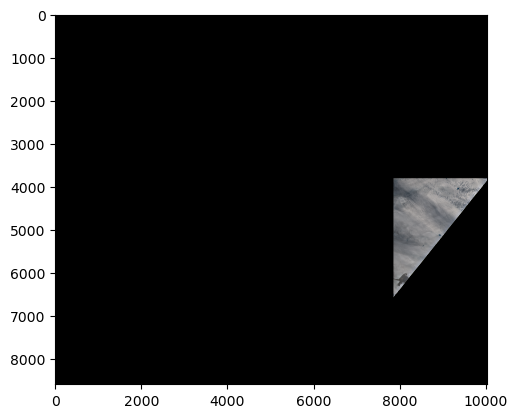

In [35]:
time=3
rgb = np.dstack((xx.red.isel(time=time).values,
                 xx.green.isel(time=time).values,
                 xx.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# Display the normalized RGB image using plt.imshow
plt.imshow(rgb_norm)

In [36]:
def stac_query(date):
    query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = date,
    
    query = {"eo:cloud_cover": {"lt": 10}}
    )
    bbox = upvk_mel.geometry.total_bounds,
    items = list(query.items())
    print(f"Found: {len(items):d} datasets")

    return items

def stac_load_help(items):
    xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=upvk_mel
    )

    return xx

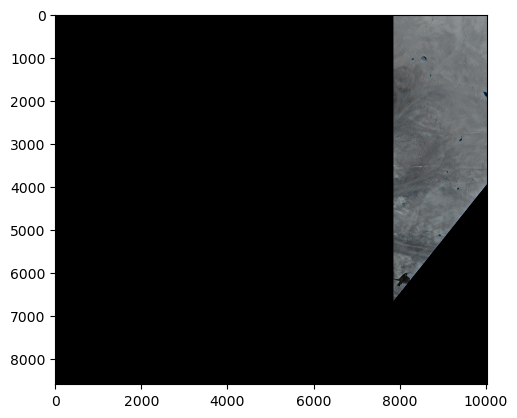

In [37]:
time=1
rgb = np.dstack((xx.red.isel(time=time).values,
                 xx.green.isel(time=time).values,
                 xx.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# Display the normalized RGB image using plt.imshow
plt.imshow(rgb_norm)

In [38]:
time=2
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

def plot_rbg(time, image_stac):
    rgb = np.dstack((image_stac.red.isel(time=time).values,
                     image_stac.green.isel(time=time).values,
                     image_stac.blue.isel(time=time).values))
    # Normalize the RGB data
    rgb_norm = rgb / np.nanmax(rgb)
    
    # Display the normalized RGB image using plt.imshow
    plt.imshow(rgb_norm)
    
def plot_rbg_rasterio(time, image_stac):
    rgb = np.dstack((image_stac.red.isel(time=time).values,
                     image_stac.green.isel(time=time).values,
                     image_stac.blue.isel(time=time).values))
    # Normalize the RGB data
    rgb_raster = reshape_as_raster(rgb)
    affine = image_stac.odc.affine
    show(rgb_raster, transform=affine, adjust=True)



In [39]:
items[-3]
items2keep = []

In [40]:
def stac_query_l8(date):
    query = catalog.search(
    collections = ["landsat-c2-l2"],
    datetime = date,
    query = {"eo:cloud_cover": {"lt": 10},
            'landsat:wrs_path':dict(eq="016"),
            },
    bbox = upvk_mel.geometry.total_bounds
    )

    items = list(query.items())
    print(f"Found: {len(items):d} datasets")

    return items


def stac_load_help_l8(items):
    xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue"],
    patch_url=pc.sign,
    resolution=30,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=upvk_mel
    )

    return xx

In [41]:
items2keep = []

In [42]:
items3 = stac_query_l8("2018-07")
cube_1007 = stac_load_help_l8(items3)

Found: 1 datasets


In [43]:
items3

[<Item id=LC08_L2SP_016008_20180731_02_T1>]

In [44]:
cube_1007

<xarray.Dataset> Size: 46MB
Dimensions:      (y: 2502, x: 3062, time: 1)
Coordinates:
  * y            (y) float64 20kB 8.132e+06 8.132e+06 ... 8.057e+06 8.057e+06
  * x            (x) float64 24kB 3.272e+05 3.272e+05 ... 4.19e+05 4.19e+05
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 8B 2018-07-31T15:41:58.196301
Data variables:
    red          (time, y, x) uint16 15MB dask.array<chunksize=(1, 2502, 3062), meta=np.ndarray>
    green        (time, y, x) uint16 15MB dask.array<chunksize=(1, 2502, 3062), meta=np.ndarray>
    blue         (time, y, x) uint16 15MB dask.array<chunksize=(1, 2502, 3062), meta=np.ndarray>

In [45]:
plot_rbg_rasterio(2, cube_1007)

IndexError: Index 2 is out of bounds for axis 0 with size 1

In [46]:
items2keep.append(items3[0])

In [47]:
items2keep

[<Item id=LC08_L2SP_016008_20180731_02_T1>]

In [48]:
items4 = stac_query_l8("2016-03")
cube_1503 = stac_load_help_l8(items4)

Found: 0 datasets


ValueError: Can't load empty sequence

In [49]:
plot_rbg_rasterio(3, cube_1503)

NameError: name 'cube_1503' is not defined

In [50]:
cube_1503.time

NameError: name 'cube_1503' is not defined

In [51]:
items4

[]

In [52]:
items2keep.append(items4[3])

IndexError: list index out of range

In [ ]:
items2keep

In [ ]:
items5 = stac_query_l8("2022-08")
cube_2308 = stac_load_help_l8(items5)

In [ ]:
plot_rbg_rasterio(0, cube_2308)

In [ ]:
items5

In [ ]:
items2keep.append(items5[1])
items2keep

In [ ]:
items6 = stac_query_l8("1998-08")
cube_9808 = stac_load_help_l8(items6)

In [ ]:
plot_rbg_rasterio(0, cube_9808)

In [ ]:
items2keep.append(items6[0])
items2keep

In [ ]:
items7 = stac_query_l8("2023-09")
cube_0103 = stac_load_help_l8(items7)

In [ ]:
plot_rbg_rasterio(1, cube_0103)

In [ ]:
cube_0103.odc.crs

In [ ]:
items7

In [ ]:
items2keep.append(items7[2])
items2keep

In [ ]:
import pickle

with open('upvk_image_item_list.pkl', 'wb') as f:
    pickle.dump(items2keep, f)

In [22]:
upvk_stac = stac_load(
    items2keep,
    chunks={},
    bands=["red", "green", "blue"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=upvk_mel
)


ValueError: Can't load empty sequence

In [23]:
items2keep

[]